# Passive-Active Saltwater Intrusion
### Simple model built to test the case study in Marina, CA 

##### Original publication on passive-active SWI:
Werner, A.D., 2017. On the classification of seawater intrusion. Journal of Hydrology, 551, pp.619-631.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
import scipy.stats as sts
#Name model
modelname = 'passive_active'

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
import SGD

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

if sys.platform == "darwin":
    model_ws = os.path.join('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD','work',modelname)
elif sys.platform == "win32":
    model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe #set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))

3.6.8 |Anaconda custom (x86_64)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
flopy version: 3.2.10
Model workspace: /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/passive_active


### Utility functions


## First let's reconstruct Werner's model


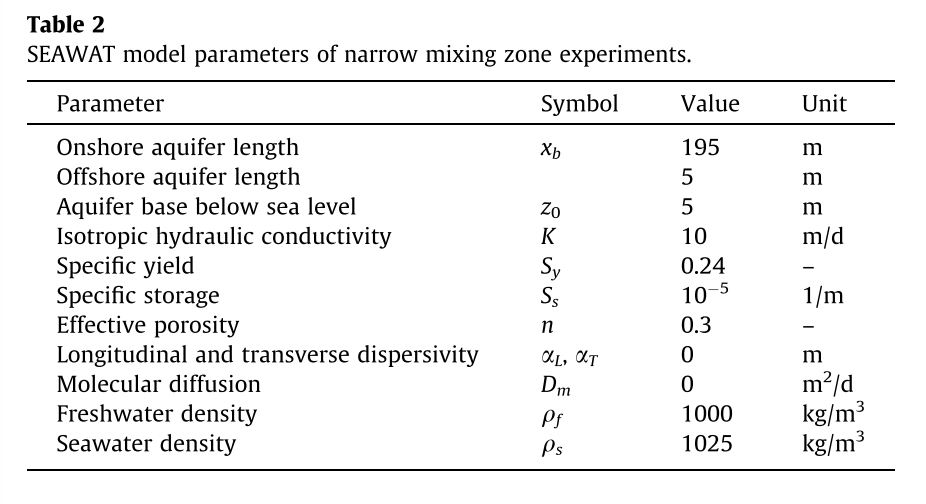

In [2]:
#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m

Lx = 200.
Ly = 1.
Lz = 6.

henry_top = 1
ocean_elev = 0
delv_first = .1
botm_first = henry_top-delv_first

nlay = int(Lz*10)
nrow = int(Ly*1)
ncol = int(Lx*(1/2))

delv = (Lz-delv_first) / (nlay-1)
delr = Lx / ncol
delc = Ly / nrow

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]

beachslope = .05
ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
inland_elev = beachslope*ocean_col[0]*delr
offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
Lt = 360*5 #Length of time in days
perlen = list(np.repeat(180,int(Lt/180)))
nstp = list(np.ones(np.shape(perlen),dtype=int))

nper = len(perlen)
steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.8
ssm_data = None
verbose = True

In [3]:
#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)

passive_active.nam
adding Package:  DIS


In [5]:
#Hydraulic conductivity field 
hkSand = 10.  #horizontal hydraulic conductivity m/day
hkClay = hkSand*.01
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background

#Set Hydraulic properties
hk = lithmat
sy = 0.24
ss = 1e-5
por = 0.3
vka = 1 # = vk/hk
al = 0 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 0 #m2/day  

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

In [6]:
def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                continue
    return new_weldata, new_ssmdata

In [7]:
#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,writeyn=0,model=None,varname=None,log_backtransf=0,*args):
    smp = distclass.rvs(*args,size=size)
    if log_backtransf==1:
        smp = tuple([10**x for x in smp])
    if size==1:
        smp=smp[-1]
    if writeyn==1:
        write_sample(model.MC_file,varname,distclass,smp)
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

#### Boundary Conditions:

In [8]:
#BCs
bc_ocean = 'GHB'
bc_right_edge = 'GHB'
bc_inland = 'GHB'
add_wells = 0
n_wells = 0
rech_on = 0

#Inland
calc_inland_head = 0 #calculate from hgrad
manual_inland_head = 0.3184
start_fresh_yn = 1
ocean_shead = [ocean_elev for x in range(len(perlen))] 
ocean_ehead = ocean_shead

# save cell fluxes to unit 53
ipakcb = 53

#Create ocean boundary at top of model
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool


if calc_inland_head == 1:
    head_inland = ocean_col[0]*delc*hgrad + ocean_elev
else:
    head_inland = manual_inland_head

####IN TESTING#####
#Create a line of where the ocean is, and any nodes on right edge below ocean
offshore_lay = (np.abs(henry_botm-offshore_elev)).argmin().astype('int')
if ocean_col[0] == ncol-1:
    ocean_line = []
    bc_ocean = 'XXX'
else:
    ocean_line = get_line((0,ocean_col[0]),(offshore_lay,ocean_col[1]),allrows=1,nrow=1)

ocean_line_tuple = tuple(np.array(ocean_line).T) #use this for indexing numpy arrays
right_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0]))
left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0]),
                                col=0)

#Create ibound
ibound,ocean_hf = shade_above(nlay,nrow,ncol,ocean_line) #don't set ibound of ocean
#ibound[:right_edge[0][0],right_edge[1][0],right_edge[2][0]] = 0
#ibound[:right_edge[0][0],right_edge[1][0],0] = 0

if bc_ocean == 'GHB':
    ibound[ocean_line_tuple]=1


#Set starting heads
strt = np.zeros((nlay,nrow,ncol),dtype=np.int)


#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

if ocean_hf:
    sconc[ocean_hf[0:3]] = Csalt
sconc[right_edge] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
### If using SSM, I think we don't need to hold cells as constant concentration
#icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head
#icbund[:,:,0] = -1 #right now hold inland boundary to constant concentration
icbund[np.where(ibound==-1)] = -1

def make_bc_dicts():
    #Ocean and inland boundary types
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    chd_data = {}
    ssm_data = {}
    ghb_data = {}
    wel_data = {}
    for i in range(nper):
        dat_chd = []
        dat_ssm = []
        dat_ghb = []
        dat_wel = []
        #Ocean boundary
        if ocean_hf:
            for j in range(np.size(ocean_hf[0])):
                if bc_ocean=='CHD':
                    #CHD: {stress_period: [lay,row,col,starthead,endhead]}
                    dat_chd.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                ocean_shead[i],
                                ocean_ehead[i]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                Csalt,
                                itype['CHD']])
                elif bc_ocean=='GHB':
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    #conductance c = K*A/dL; assume horizontal flow at outlet,
                    #and calculate length to be at edge of ocean cell, as opposed to mipoint
                    # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                    dat_ghb.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   #ocean_hf[3][j],
                                    ocean_elev,
                                   2*hkSand*delc*delv_vec[ocean_hf[0][j]]/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   Csalt,
                                   itype['GHB']])
        else:
            pass
        #Right edge boundary
        if bc_right_edge=='GHB':
            for j in range(np.size(right_edge[0])):
                #GHB: {stress period: [lay,row,col,head level,conductance]}
                #conductance c = K*A/dL; assume horizontal flow at outlet,
                #and calculate length to be at edge of ocean cell, as opposed to mipoint
                # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                dat_ghb.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               #ocean_hf[3][j],
                                ocean_elev,
                               2*hkSand*delc*delv_vec[right_edge[0][j]]/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               Csalt,
                               itype['GHB']])
        else:
            pass
        #Inland boundary
        if bc_inland=='GHB':
            for j in range(np.size(left_edge[0])):
                dat_ghb.append([left_edge[0][j],
                               left_edge[1][j],
                               left_edge[2][j],
                                head_inland,
                               2*hkSand*delc*delv_vec[left_edge[0][j]]/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([left_edge[0][j],
                               left_edge[1][j],
                               left_edge[2][j],
                               Cfresh,
                               itype['GHB']])
        elif bc_inland=='WEL':
            for j in range(nlay):
                for k in range(nrow):
                    #WEL: {stress_period: [lay,row,col,flux]}
                    dat_wel.append([j,k,0,influx*delv_weight[j]/nrow])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['WEL']])
        chd_data[i] = dat_chd
        ssm_data[i] = dat_ssm
        ghb_data[i] = dat_ghb
        wel_data[i] = dat_wel

    #saving concentrations at specified times
    #timprs = [k for k in range(1,np.sum(perlen),50)]
    return chd_data, ssm_data, ghb_data, wel_data

chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()
wel_data_base,ssm_data_base = wel_data,ssm_data
timprs = np.round(np.linspace(1,np.sum(perlen),20),decimals=0)

create_MC_file()
save_obj(m.MC_file.parent,wel_data_base,'wel_data_base')
save_obj(m.MC_file.parent,ssm_data_base,'ssm_data_base')


/Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/passive_active/MC_expt_2019-02-01-14-34/expt.txt


### Notes on Farm fields
North Marina Area: 
Fields can be as close as 400m from the coast!! Others closer to 1.7km

Most fields are about 200x200m, some fields that appear to be row crops (strawberry? lettuce?) are 100x100 or so

Fields are in a 3 distinct patches, each patch is almost completely covered with crops:

-Near coast (400m+), verdant larger plots.

-1.7km inland, pale colored, tight rows

-2.75km inland, larger plots, varied color


Salinas Valley:
Most fields are about 200-250m wide minimum and can be 300-600m long


In [9]:
#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']

In [10]:
#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='CHD' or bc_inland=='CHD' :
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

if m.rch:
    m.rch = None

# Add LPF package to the MODFLOW model
#lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1,laywet=1,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

adding Package:  BAS6
adding Package:  GHB
Adding passive_active.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding passive_active.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
adding Package:  SSM
adding Package:  VDF


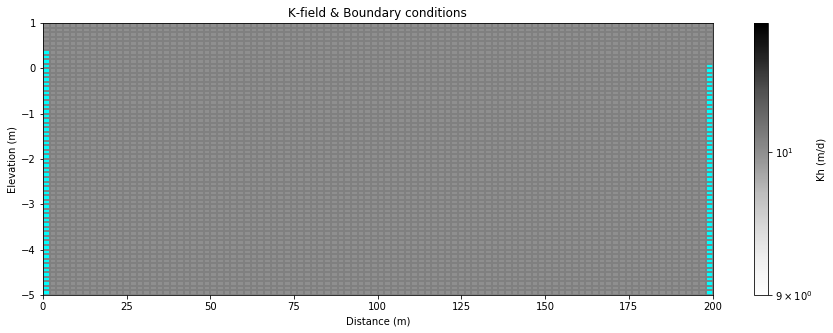

In [11]:
printyn = 0
gridon=1
rowslice=0
m.plot_hk_ibound(rowslice=rowslice,printyn=printyn,gridon=gridon);


In [12]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 


In [13]:
#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: passive_active.nam                                                                                                                                                                                      
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/02/01 14:34

## Post-processing results

In [14]:
#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',per=-1,scale=50,rowslice=0):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[per]
    qz = budobj.get_data(text='FLOW LOWER FACE')[per]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, rowslice, ::iskip], -qz_avg[::iskip, rowslice, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection

def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique

def kstpkper_from_time(ucnobj,tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)    
    kstpkper = kstpkpers[timeind]
    return kstpkper

def kstpkper_ind_from_kstpkper(ucnobj,kstpkper=(0,0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind

def get_salt_outflow(m,kstpkper=None,totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    totim = ucnobj.get_times()[-1]
    if kstpkper==None:
        kstpkper = ucnobj.get_kstpkper()[-1]
    ocean_conc = ucnobj.get_data(kstpkper=kstpkper)
    return ocean_conc
    
def plot_background(mm,array,label=None):
    if label==None:
        label = [k for k,v in globals().items() if v is array][-1]
    if label=='hk':
        norm=matplotlib.colors.LogNorm()
        vmin=hkClay
        vmax=hkSand
        cmap='jet'
    else:
        norm = None
        vmin=None
        vmax=None
        cmap='jet'
    cpatchcollection = mm.plot_array(array,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    cpatchcollection.set_label(label)
    return cpatchcollection,label

def plot_mas(m):
    # Load the mas file and make a plot of total mass in aquifer versus time
    fname = os.path.join(m.model_ws, 'MT3D001.MAS')
    mas = flopy.mt3d.Mt3dms.load_mas(fname)
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('Time (d)')
    plt.ylabel('Mass (kg)')
    plt.title('Mass of salt within model through time')
    lines = ax.plot(mas.time, mas.total_mass)
    plt.show()
    return mas

In [16]:
# Extract final timestep heads
per = -1
def extract_hds_conc(per):
    fname = os.path.join(model_ws, '' + modelname + '.hds')
    hdobj = flopy.utils.binaryfile.HeadFile(fname)
    times = hdobj.get_times()
    print('Head object kstpkper:',hdobj.get_kstpkper())
    hds = hdobj.get_data(totim=times[per])
    hds[np.where(ibound != 1)] = np.nan
    hds[np.where((hds>1e10) | (hds<-1e10))] = np.nan
    
    # Extract final timestep salinity
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    times = ucnobj.get_times()
    kstpkper = ucnobj.get_kstpkper()
    conc = ucnobj.get_data(totim=times[per])
    conc[np.where(ibound != 1)] = np.nan
    conc[np.where((conc>1e10) | (conc<-10))] = np.nan
    return conc,hds

conc,hds = extract_hds_conc(per)

Head object kstpkper: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


In [17]:
# Make head and quiver plot
import utils
def basic_plot(per,backgroundplot):
    printyn = 1
    rowslice = 0

    f, axs = plt.subplots(1, figsize=(6, 4))

    plt.tight_layout()

    #Plot discharge and ibound
    mm = flopy.plot.ModelCrossSection(ax=axs, model=m, line={'row':rowslice})

    #Plot background
    backgroundpatch,lbl = cpatchcollection,label = plot_background(mm,backgroundplot,'conc(g/L)')
    lvls = Cfresh + (Csalt-Cfresh)*np.array([.05,.5,.95])
    #CS = mm.contour_array(conc,head=hds,levels=lvls,colors='white')
    #plt.clabel(CS, CS.levels, inline=True, fontsize=10)

    #mm.contour_array(hds,head=hds)
    mm.plot_ibound()
    mm.plot_bc(ftype='GHB',color='white')
    if m.Wel:
        mm.plot_bc(ftype='WEL',color='black')
    #Plot discharge
    utils.plotdischarge(m,color='white',per=per,scale=.1,rowslice=rowslice,iskip=5);
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.subplots_adjust(bottom=.1)

    #align plots and set colorbar
    f.subplots_adjust(left=.1,right=0.88)
    cbar_ax = f.add_axes([0.90, 0.1, 0.02, 0.7])
    cb = f.colorbar(cpatchcollection,cax=cbar_ax)
    cb.set_label(label)
    if printyn == 1:
        plt.savefig(os.path.join(m.model_ws, m.name + '_' + ts + '_flowvec_row' + str(rowslice) +
                                 '_per' + str(per) + '_' + lbl[:3] + '.png'),dpi=150)
    plt.show()
    return mm


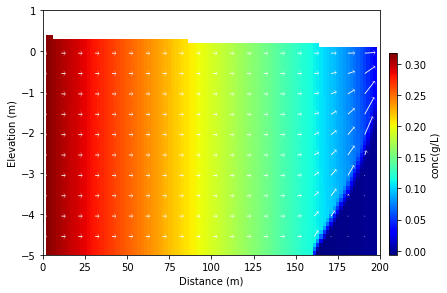

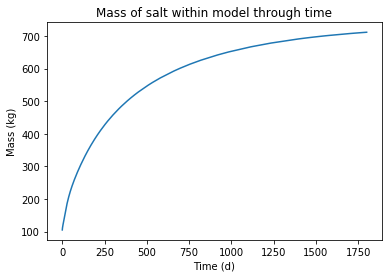

In [19]:
basic_plot(per,hds)
mas = plot_mas(m)

## Now with recharge
#### Case 5a from Werner (2017), but recharge reduced to 0.001 m/day


In [186]:

##Add recharge data
#rech = 0.00285 #m/d
rech = 0.001 #m/d
rech_data = rech

#Adjust head inland
head_inland = -0.5214


right_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0]))
left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0])+1,
                                col=0)

#Create ibound
ibound = np.ones((nlay,nrow,ncol))
#ibound[:right_edge[0][0],right_edge[1][0],right_edge[2][0]] = 0
#ibound[:left_edge[0][0],left_edge[1][0],left_edge[2][0]] = 0
strt = min(ocean_elev,head_inland)

#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

sconc[right_edge] = Csalt
sconc[left_edge] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
icbund[np.where(ibound==-1)] = -1
chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()


NameError: name 'flopy' is not defined

##### Reassign values to flopy model, write files, then run

In [187]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if m.Chd:
    m.Chd = None
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

rch = flopy.modflow.ModflowRch(m, rech=rech_data)

# Add LPF package to the MODFLOW model
#lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1,laywet=1,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
****Warning -- two packages of the same type:  <cl

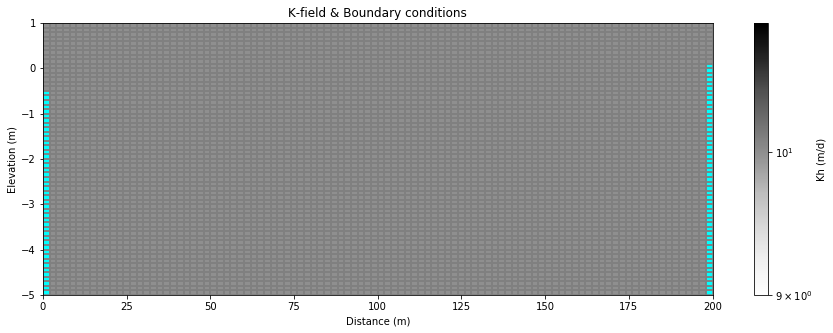

In [188]:
printyn = 0
gridon=1
rowslice=0
m.plot_hk_ibound(rowslice=rowslice,printyn=printyn,gridon=gridon);


In [189]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass

#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
   Package:  RCH
 
FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: passive_active.nam     

Head object kstpkper: [(0, 0), (0, 1), (0, 2), (0, 3)]


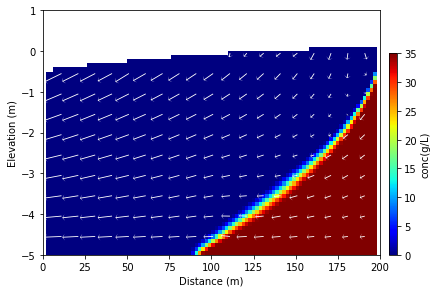

In [190]:
per=-1
conc,hds = extract_hds_conc(per)
conc[np.where((conc==1e30) | (conc==-1e30))]=np.nan
basic_plot(per,conc)

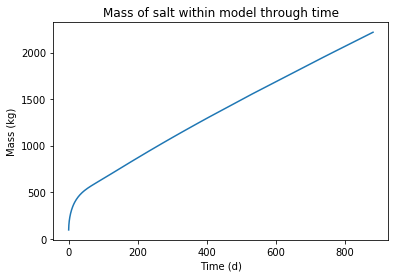

In [191]:
mas = plot_mas(m)

### Now let's apply the problem to the Marina, CA situation
Here, we still have passive-active SWI, but the recharge is not applied across the entire water table. Instead, the 180-Foot Aquifer is recharged by the overlying Dune Sand Aquifer where the aquitard separating the units terminates.

We will approximate this situation as a 2-D cross section, where recharge is applied at one point

75.0

In [180]:
#We will assume that all water that would have directly recharged the WT ...
# is now recharging at the specific recharge column

rech_col = np.arange(int(ncol*.5),int(ncol*.5)+30)
rech_rate = 0.00285*ncol/len(rech_col)
rech_rate = 0.001*ncol/len(rech_col)

rech_data = {}
rech_data = np.zeros((nrow,ncol))
rech_data[:,rech_col] = rech_rate


#Adjust head inland
head_inland = -0.5214

right_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0]))
left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0])+1,
                                col=0)

#Create ibound
ibound = np.ones((nlay,nrow,ncol))
strt = min(ocean_elev,head_inland)

#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

sconc[right_edge] = Csalt
sconc[left_edge] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
icbund[np.where(ibound==-1)] = -1
chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()


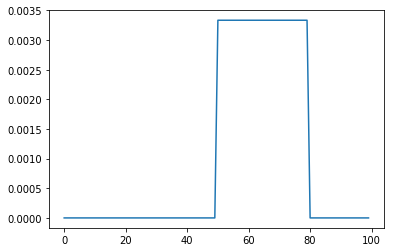

In [181]:
plt.plot(rech_data.squeeze())
plt.savefig(os.path.join(m.model_ws, m.name + '_' + ts + '_flowvec_row' + str(rowslice) +
                                 '_per' + str(per) + '_' + lbl[:3] + '.png'),dpi=150)


In [182]:
#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

rch = flopy.modflow.ModflowRch(m, rech=rech_data)

# Add LPF package to the MODFLOW model
#lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1,laywet=1,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
adding Package:  RCH
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same t

In [183]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass

#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
   Package:  RCH
Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external
 
FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liabl

Head object kstpkper: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


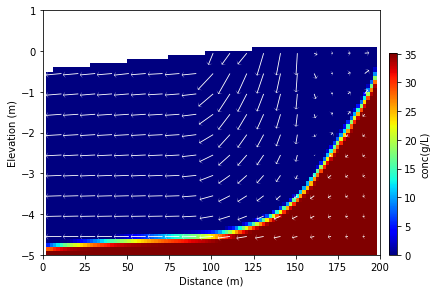

In [184]:
per=-1
conc,hds = extract_hds_conc(per)
conc[np.where((conc==1e30) | (conc==-1e30))]=np.nan
basic_plot(per,conc)

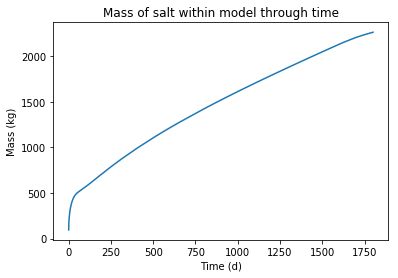

In [185]:
_ = plot_mas(m)

#### Now let's add a well to see what could happen in this case

In [160]:
#We will assume that all water that would have directly recharged the WT ...
# is now recharging at the specific recharge column

rech_col = np.arange(int(ncol*.5),int(ncol*.5)+30)
rech_rate = 0.001*ncol/len(rech_col)

rech_data = {}
rech_data = np.zeros((nrow,ncol))
rech_data[:,rech_col] = rech_rate


#Adjust head inland
head_inland = -0.5214

right_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0]))
left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0])+1,
                                col=0)

#Create ibound
ibound = np.ones((nlay,nrow,ncol))
strt = min(ocean_elev,head_inland)

#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

sconc[right_edge] = Csalt
sconc[left_edge] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
icbund[np.where(ibound==-1)] = -1
chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()

#Add well data
drawdown = 1.5 #m
qout = -sy*drawdown*delr*delc
wel_col = int(ncol*.95)
wel_top_lay = int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0])
wel_data = {}
for i in range(nper):
    dat_wel = []
    for j in range(wel_top_lay,nlay):
        for k in range(nrow):
            #WEL: {stress_period: [lay,row,col,flux]}
            dat_wel.append([j,k,wel_col,qout*delv_weight[j]/(np.sum(delv_weight[wel_top_lay:]))])
            #SSM: {stress_period: [lay,row,col,concentration,itype]}
            ssm_data[i].append([j,k,wel_col,Cfresh,itype['WEL']])
    wel_data[i] = dat_wel

In [161]:
#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

rch = flopy.modflow.ModflowRch(m, rech=rech_data)
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)

# Add LPF package to the MODFLOW model
#lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1,laywet=1,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type: 

In [162]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass

#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
   Package:  RCH
Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external
BaseModel.add_external() warning: replacing existing filename rech_0.ref
   Package:  WEL
 
FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition t

Head object kstpkper: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


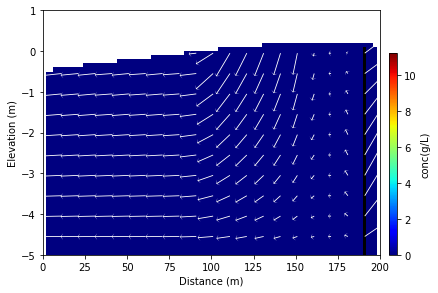

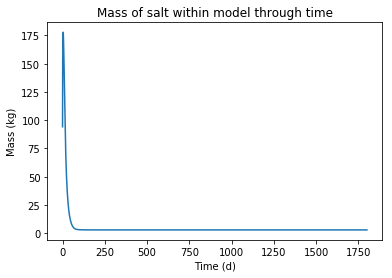

In [163]:
per=-1
conc,hds = extract_hds_conc(per)
bckground = conc



bckground[np.where((bckground==1e30) | (bckground==-1e30))]=np.nan
mm = basic_plot(per,bckground)
_ = plot_mas(m)

In [157]:
mm.plot_bc(ftype='WEL')


# Reading in real data

cmap='jet'

plt.scatter(flowsheet.X,flowsheet.Y,s=flowsheet.Flow,c=100-flowsheet.pctFW,cmap=cmap,vmin=0,vmax=100)
